In [108]:
# set path
import os
import sys
my_path = os.path.abspath(os.path.dirname('.'))
path = os.path.join(my_path, "..")
sys.path.insert(1, path)

In [109]:
# load modules
import pandas as pd
from extract import extracted_data_analyzer as eda, aact_querier as aq
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import psycopg2
import getpass
import pandas.io.sql as psql
import plotly.express as px
import imageio
import pycountry as pc
from plotly.offline import iplot
from matplotlib.pyplot import *

In [110]:
#configs
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [111]:
## Functions for data exploration and visualization

In [112]:
def ctgov_data_prep(df):
    # Rename and format columns
    if '#nct_id' in df.columns:
        df.rename(columns={'#nct_id':'nct_id'}, inplace=True)
        
    if 'start_date' in df.columns:
        df['start_datetime']=pd.to_datetime(df['start_date'], format='%Y-%m-%d')
        df['start_year'] = df['start_datetime'].dt.to_period('Y')

In [113]:
def annual_stacked_bar(og_df, colname=None, collabel=None, start_year=2000, end_year=2021, style='white', palette='muted', colors=10, reverse=False, legend=True):
    # set the figure size
    df=og_df.copy()
    plt.figure()
    sns.set(rc={'figure.figsize':(16.18,10)})
    sns.set(style=style)
    seapal=sns.color_palette(palette = palette, n_colors = colors, desat = None)
    sns.set_palette(seapal)
    
    #create stacked bar chart
    if colname is None:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year"])['nct_id'].nunique()        
        filepath="./visuals/stacked_bar_aggregate.png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)
        plt.title('Trials by Year', fontsize=16)        
    else:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year",colname])['nct_id'].nunique().unstack(colname).fillna(0)
        filepath="./visuals/stacked_bar_"+colname+".png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)
        
        title="Trials by "+colname
        if collabel is not None:
            title="Trials by "+collabel
            
        plt.title(title, fontsize=16)
        
    



    #add axis titles
    plt.xlabel('Trial Start Year')
    plt.ylabel('Number of Trials')
    
    if legend:
        plt.legend(bbox_to_anchor=(1.2,0.5) , loc='center right') 
    
    
    
    plt.savefig(filepath, bbox_inches='tight')
    return pivot.reset_index()

    #rotate x-axis labels
    # plt.xticks(rotation=45)

In [114]:
def annual_stacked_bar_100(og_df, colname=None, collabel=None, start_year=2000, end_year=2021, style='white', palette='muted', colors=10, reverse=False):
    # set the figure size
    df=og_df.copy()
    plt.figure()
    sns.set(rc={'figure.figsize':(16.18,10)})
    sns.set(style=style)
    seapal=sns.color_palette(palette = palette, n_colors = colors, desat = None)
    sns.set_palette(seapal)
    
    #create stacked bar chart
    if colname is None:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year"])['nct_id'].nunique()       
        filepath="./visuals/stacked_bar_100_aggregate.png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)
        plt.title('Trials by Year', fontsize=16)
        
        #add axis titles
        plt.xlabel('Trial Start Year')
        plt.ylabel('Proportion of Trials')
        plt.legend(bbox_to_anchor=(1.2,0.5) , loc='center right') 
        plt.savefig(filepath, bbox_inches='tight')

    else:
        pivot = df[(df.start_datetime.dt.year>=start_year)&(df.start_datetime.dt.year<=end_year)].groupby(["start_year"])[colname].value_counts(normalize=True).unstack(colname).fillna(0)
        filepath="./visuals/stacked_bar_100_"+colname+".png"
        if reverse:
            pivot.sort_index(axis=1, ascending=False).plot.bar(stacked=True)
        else:
            pivot.plot.bar(stacked=True)

        title="Trials by "+colname
        if collabel is not None:
            title="Trials by "+collabel
            
        plt.title(title, fontsize=16)
        #add axis titles
        plt.xlabel('Trial Start Year')
        plt.ylabel('Proportion of Trials')
        plt.legend(bbox_to_anchor=(1.2,0.5) , loc='center right') 
        plt.savefig(filepath, bbox_inches='tight')
        plt.show()
        
        pie_title=str(end_year)+" Trials by "+colname
        if collabel is not None:
            pie_title=str(end_year)+" Trials by "+collabel
        
        if reverse:
            plt.pie(pivot.sort_index(axis=1, ascending=False).reset_index()[pivot.sort_index(axis=1, ascending=False).reset_index().start_year.dt.year==end_year].iloc[0, 1:].tolist(), labels = pivot.sort_index(axis=1, ascending=False).reset_index()[pivot.sort_index(axis=1, ascending=False).reset_index().start_year.dt.year==end_year].columns[1:].tolist(), autopct='%.0f%%')
        else:
            plt.pie(pivot.reset_index()[pivot.reset_index().start_year.dt.year==end_year].iloc[0, 1:].tolist(), labels = pivot.reset_index()[pivot.reset_index().start_year.dt.year==end_year].columns[1:].tolist(), autopct='%.0f%%')
        
        
        plt.title(pie_title, fontsize=16)
        pie_path="./visuals/stacked_pie_100_"+colname+str(end_year)+".png"
        plt.savefig(pie_path, bbox_inches='tight')
        plt.show()
        
    



    
    
    
    return pivot.reset_index()

    #rotate x-axis labels
    # plt.xticks(rotation=45)

In [115]:
## Explore cancer trials

In [116]:
path

'/Users/forrest.xiao/non_fh_code/trialtracker/analysis/..'

In [117]:
# All cancer trials
onc_trials=pd.read_csv(path+"/extract/extracted_data/ct_fb_parser_data.csv", index_col=0)

In [118]:
onc_trials.head()

,#nct_id,title,has_us_facility,conditions,eligibility_criteria,start_date,lead_sponsor,summary,overall_status,phase,enrollment,enrollment_type,study_type,number_of_arms,number_of_groups,why_stopped,has_dmc,is_fda_regulated_drug,is_fda_regulated_device,is_unapproved_device,is_ppsd,is_us_export
0,NCT00000105,Vaccination With Tetanus and KLH to Assess Imm...,True,Cancer,Inclusion Criteria:\n\nPatients must have a di...,2002-07-31,"Masonic Cancer Center, University of Minnesota",The purpose of this study is to learn how the ...,Terminated,NaN,112.0,Actual,Observational,NaN,3.0,Replaced by another study.,True,NaN,NaN,NaN,NaN,NaN
1,NCT00000124,Collaborative Ocular Melanoma Study (COMS),False,Choroid Neoplasms|Uveitis,Men and women eligible for the study must be a...,1986-11-30,National Eye Institute (NEI),To evaluate therapeutic interventions for pati...,Unknown status,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NCT00000589,Trial to Reduce Alloimmunization to Platelets ...,False,Blood Platelets|Blood Transfusion|Hematologic ...,"Male and female thrombocytopenic patients, age...",1989-08-31,"National Heart, Lung, and Blood Institute (NHLBI)","To determine the best, clinically useful proce...",Completed,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCT00000591,T-Cell Depletion in Unrelated Donor Marrow Tra...,False,Bone Marrow Transplantation|Graft vs Host Dise...,No eligibility criteria,1993-11-30,"National Heart, Lung, and Blood Institute (NHLBI)",To determine if a reduction in morbidity and m...,Completed,Phase 3,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NCT00000603,Cord Blood Stem Cell Transplantation Study (CO...,False,"Anemia, Aplastic|Fanconi Anemia|Hematologic Di...",Mothers of Infant-donors must complete a medic...,1996-09-30,"National Heart, Lung, and Blood Institute (NHLBI)","To evaluate if HLA-mismatched, unrelated-donor...",Completed,Phase 2,NaN,NaN,Interventional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
ctgov_data_prep(onc_trials)

In [120]:
# Clean phase column
# onc_trials['phase'].fillna('Null', inplace=True)
phase_map={'Early Phase 1':'a) Early Phase 1',
           'Phase 1':'b) Phase 1',
           'Phase 1/Phase 2':'c) Phase 1/Phase 2',
           'Phase 2':'d) Phase 2',
           'Phase 2/Phase 3':'e) Phase 2/Phase 3',
           'Phase 3':'e) Phase 3',
           'Phase 4':'f) Phase 4',
           'Not Applicable':'g) Not Applicable'
          }

onc_trials['mapped_phase']=onc_trials['phase'].map(phase_map).fillna('h) Missing')

In [121]:
# Clean study column
# onc_trials['phase'].fillna('Null', inplace=True)
study_type_map={'Interventional':'a) Interventional',
           'Observational':'b) Observational',
           'Observational [Patient Registry]':'c) Observational [Patient Registry]',
           'Expanded Access':'d) Expanded Access',
          }

onc_trials['mapped_study_type']=onc_trials['study_type'].map(study_type_map).fillna('e) Missing')

In [122]:
#Summary stats and figures

In [123]:
onc_trial_count=onc_trials[(onc_trials.start_datetime.dt.year>=2000)&(onc_trials.start_datetime.dt.year<=2021)]['nct_id'].nunique()
print(f"{onc_trial_count} cancer trials from 2000 to 2021.")

74643 cancer trials from 2000 to 2021.


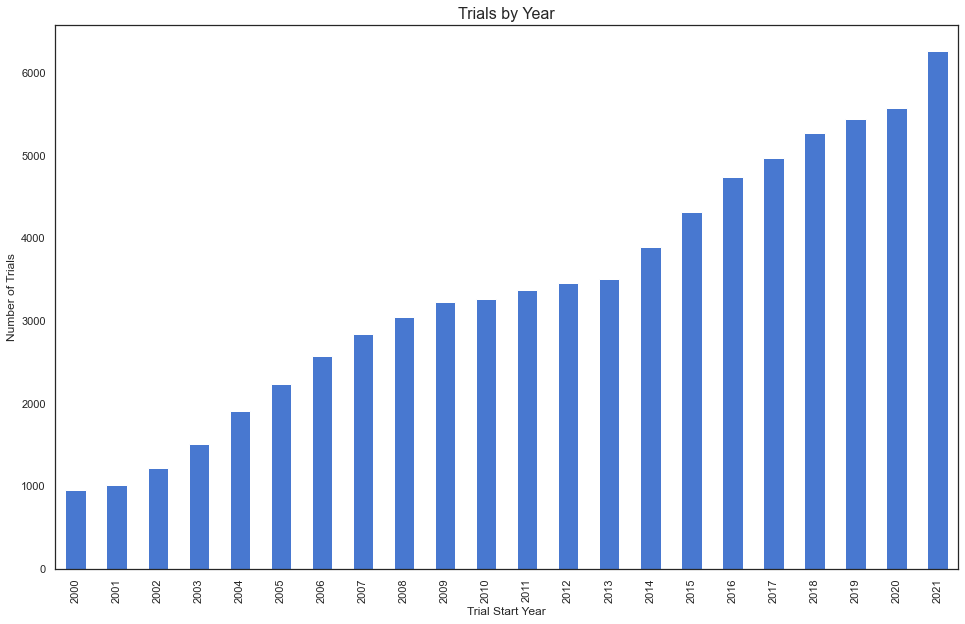

In [124]:
#Overall Trial Volume
df=annual_stacked_bar(onc_trials, legend=False)

In [125]:
df.tail()

,start_year,nct_id
17,2017,4973
18,2018,5272
19,2019,5439
20,2020,5581
21,2021,6266


In [126]:
df['past_year_count'] = df['nct_id'].shift(1)
df['yoy_perc_change']=df.nct_id/df['past_year_count']-1
df.head()

,start_year,nct_id,past_year_count,yoy_perc_change
0,2000,958,NaN,NaN
1,2001,1009,958.0,0.053236
2,2002,1222,1009.0,0.211100
3,2003,1516,1222.0,0.240589
4,2004,1913,1516.0,0.261873


In [127]:
df

,start_year,nct_id,past_year_count,yoy_perc_change
0,2000,958,NaN,NaN
1,2001,1009,958.0,0.053236
2,2002,1222,1009.0,0.211100
3,2003,1516,1222.0,0.240589
4,2004,1913,1516.0,0.261873
5,2005,2235,1913.0,0.168322
6,2006,2579,2235.0,0.153915
7,2007,2841,2579.0,0.101590
8,2008,3045,2841.0,0.071806
9,2009,3234,3045.0,0.062069


In [128]:
# df.yoy_perc_change.mean()

In [129]:
df.iloc[:-1].yoy_perc_change.mean()

0.09453597656909037

<Figure size 1164.96x720 with 0 Axes>

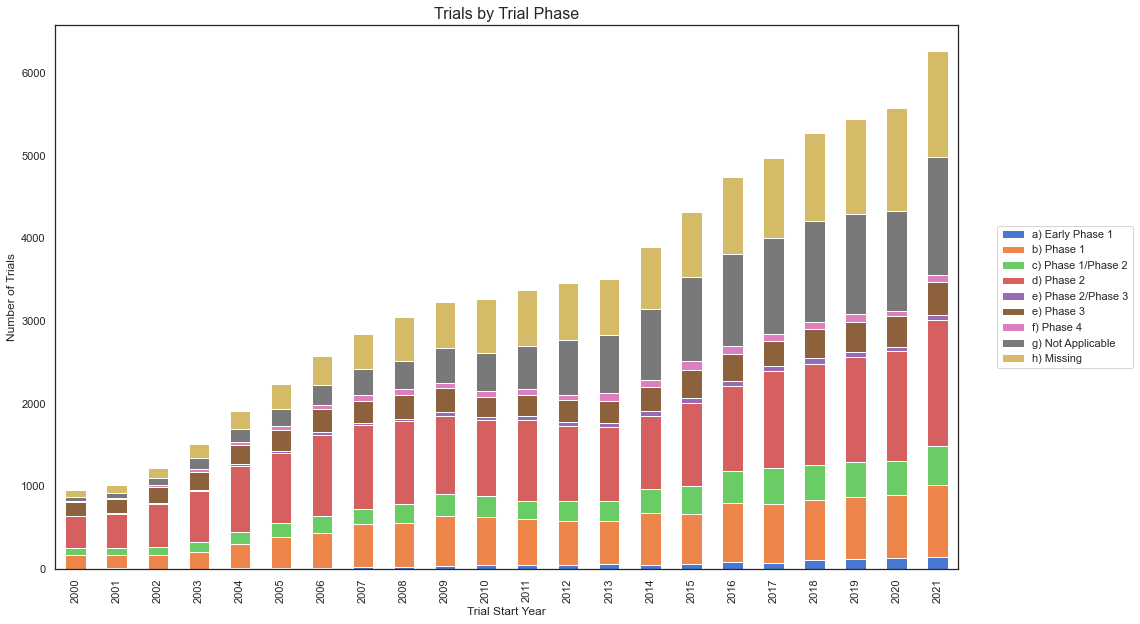

In [130]:
#Overall Trial Volume
df=annual_stacked_bar(onc_trials, colname='mapped_phase', collabel="Trial Phase")

<Figure size 1164.96x720 with 0 Axes>

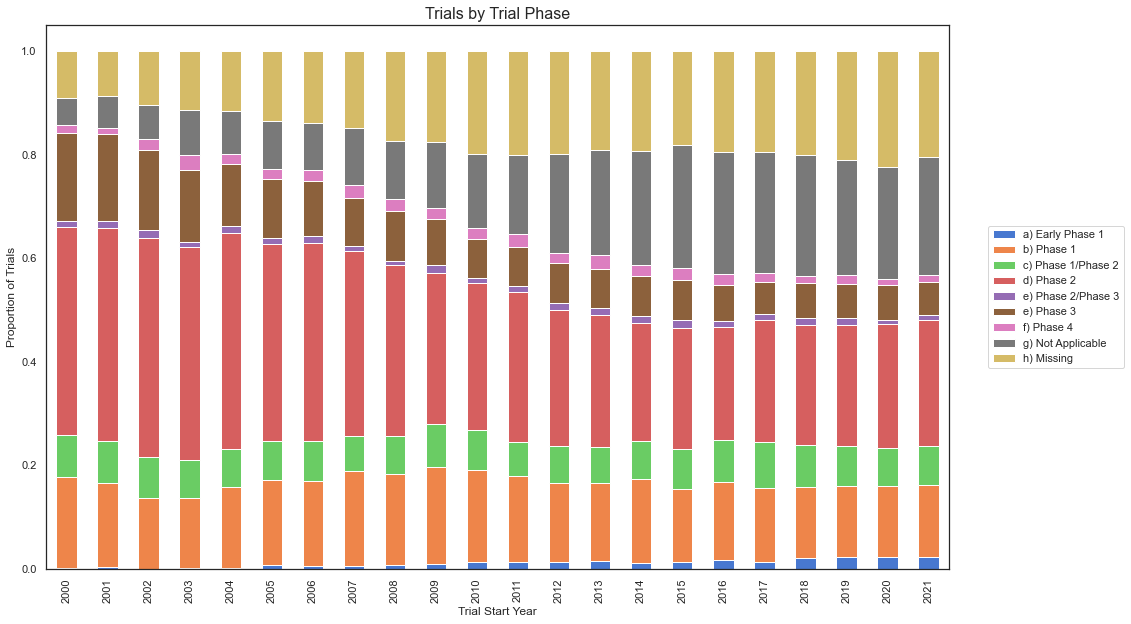

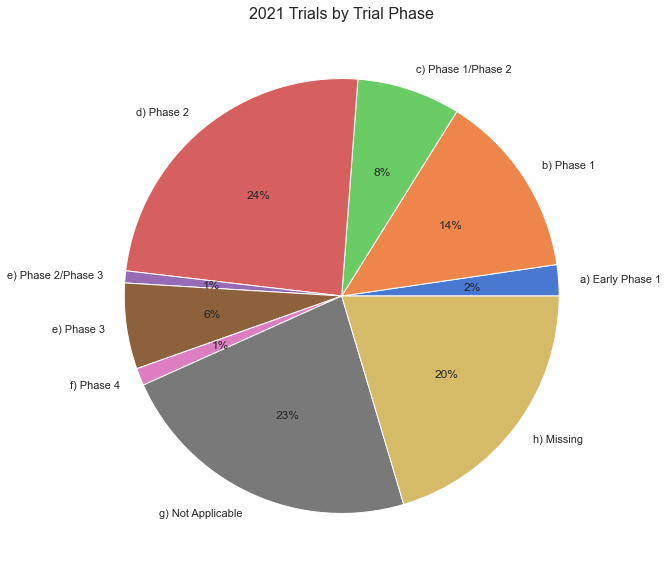

In [131]:
#Trials by Phase
df=annual_stacked_bar_100(onc_trials, colname='mapped_phase', collabel="Trial Phase")

<Figure size 1164.96x720 with 0 Axes>

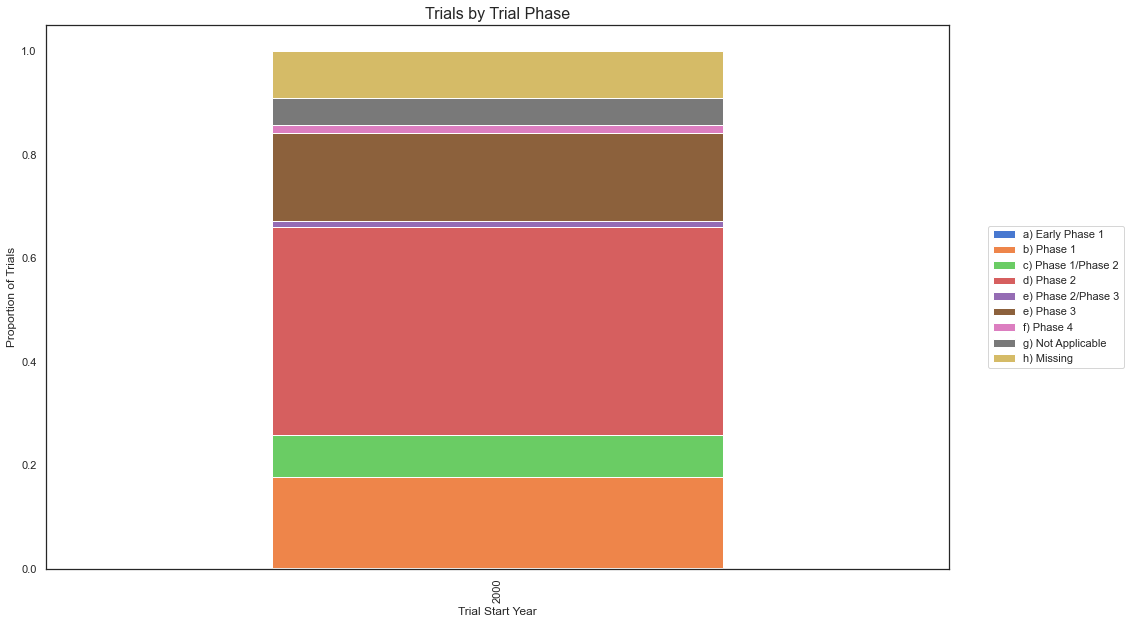

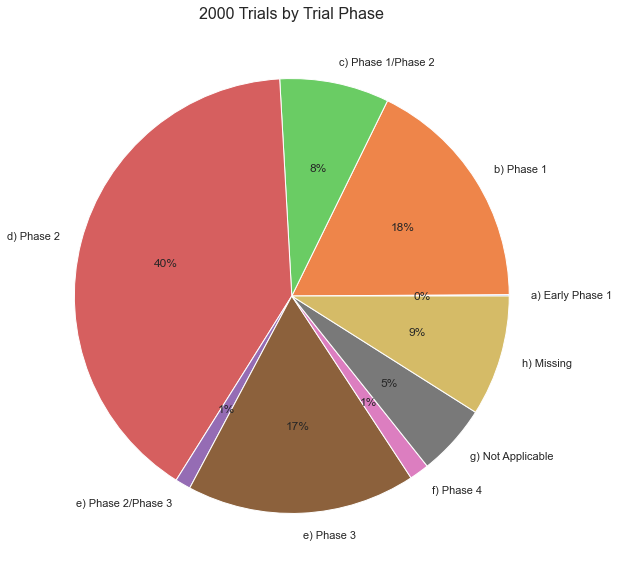

In [132]:
#2000 trials by phase
df=annual_stacked_bar_100(onc_trials, end_year=2000, colname='mapped_phase', collabel="Trial Phase")

<Figure size 1164.96x720 with 0 Axes>

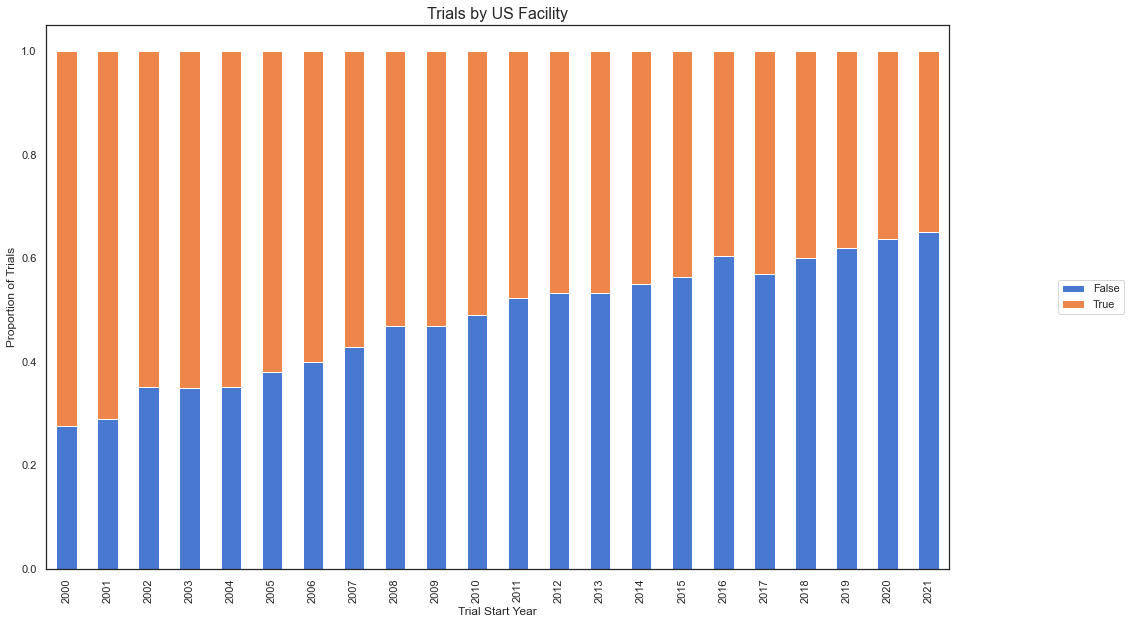

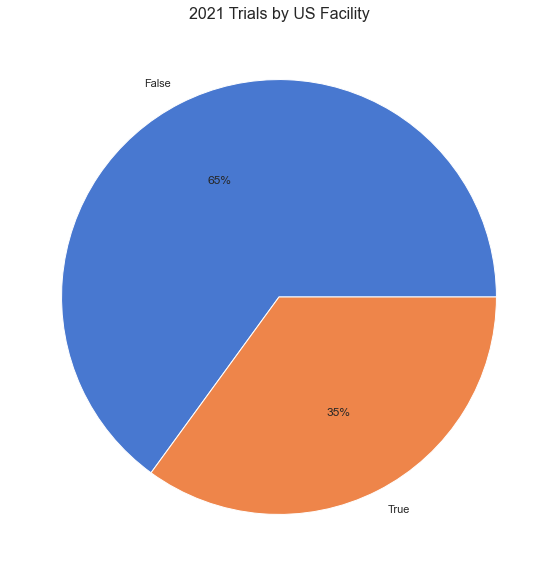

In [133]:
#Trials by Site
df=annual_stacked_bar_100(onc_trials, colname='has_us_facility', collabel="US Facility")

<Figure size 1164.96x720 with 0 Axes>

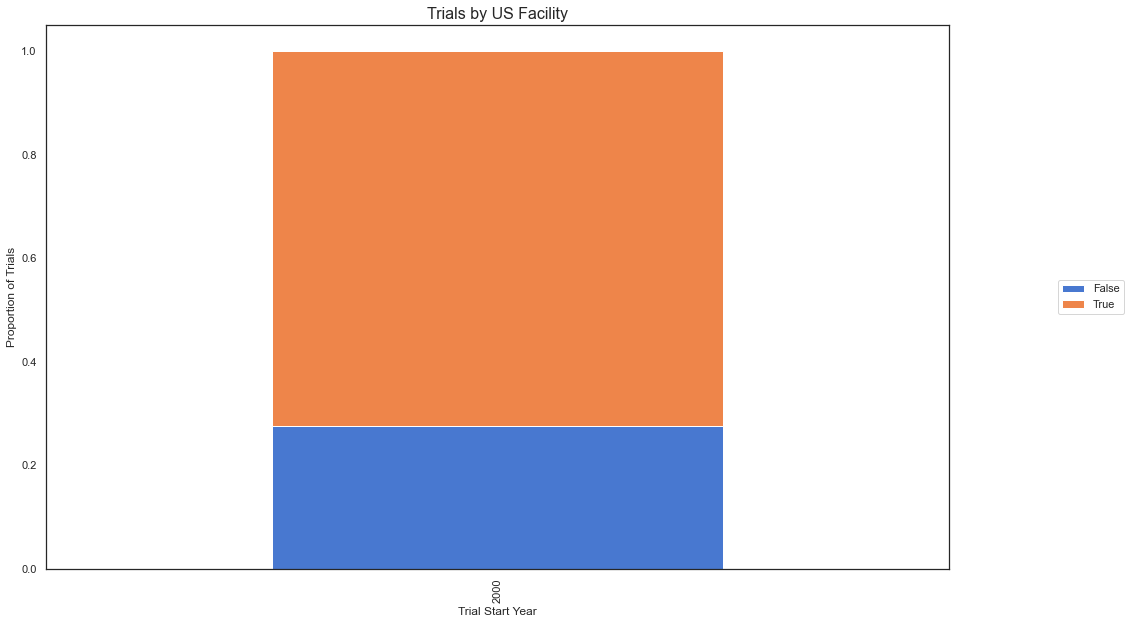

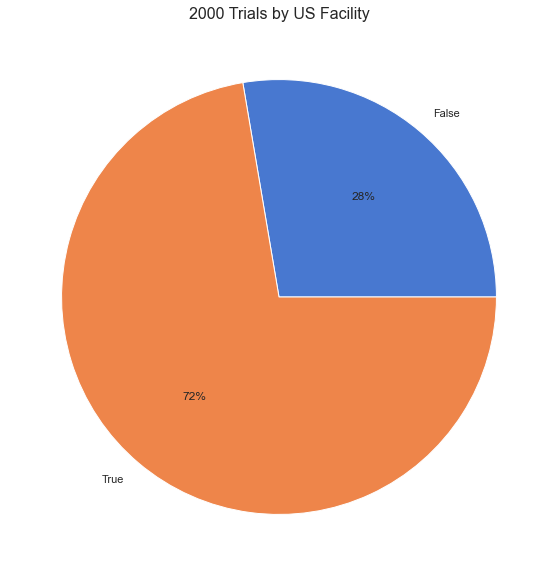

In [134]:
#2000 trials by facility
df=annual_stacked_bar_100(onc_trials, end_year=2000, colname='has_us_facility', collabel="US Facility")

<Figure size 1164.96x720 with 0 Axes>

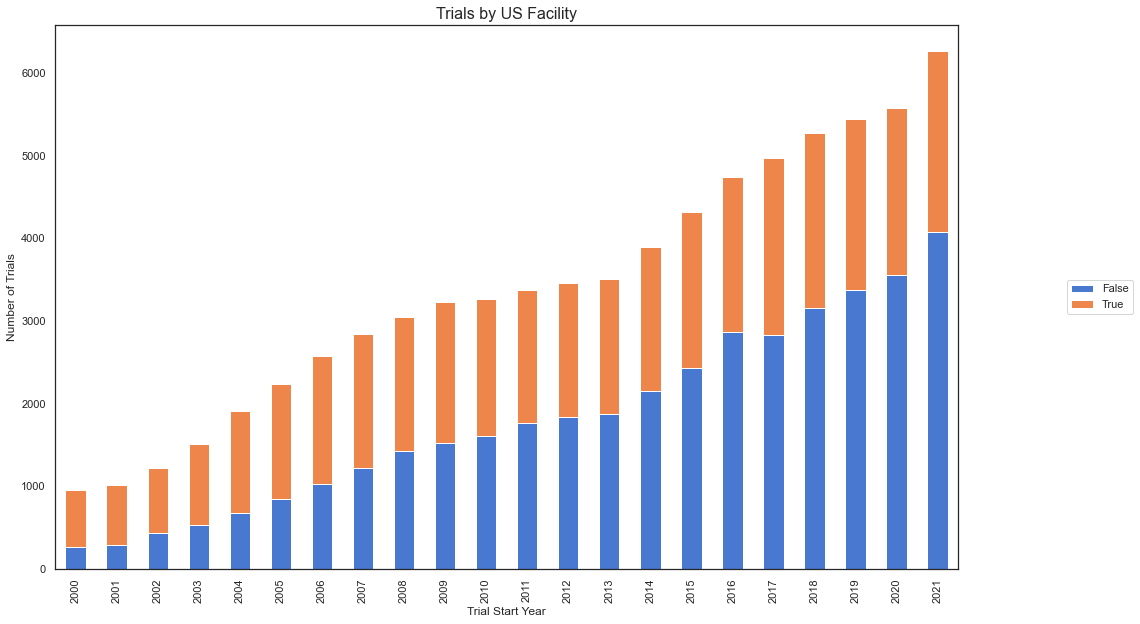

In [135]:
df=annual_stacked_bar(onc_trials, colname='has_us_facility', collabel="US Facility")

In [136]:
df.head()

has_us_facility,start_year,False,True
0,2000,265,693
1,2001,291,718
2,2002,430,792
3,2003,528,988
4,2004,673,1240


In [137]:
df.tail()

has_us_facility,start_year,False,True
17,2017,2832,2141
18,2018,3162,2110
19,2019,3371,2068
20,2020,3550,2031
21,2021,4072,2194


In [46]:
df.columns = df.columns.astype(str)
df.columns

Index(['start_year', 'False', 'True'], dtype='object', name='has_us_facility')

In [47]:
df['past_year_count_true'] = df['True'].shift(1)
df['yoy_perc_change_true']=df['True']/df['past_year_count_true']-1
df['past_year_count_false'] = df['False'].shift(1)
df['yoy_perc_change_false']=df['False']/df['past_year_count_false']-1
df.head()

has_us_facility,start_year,False,True,past_year_count_true,yoy_perc_change_true,past_year_count_false,yoy_perc_change_false
0,2000,265,693,NaN,NaN,NaN,NaN
1,2001,291,718,693.0,0.036075,265.0,0.098113
2,2002,430,792,718.0,0.103064,291.0,0.477663
3,2003,528,988,792.0,0.247475,430.0,0.227907
4,2004,673,1240,988.0,0.255061,528.0,0.274621


In [48]:
print(df[df.start_year.dt.year<=2021].yoy_perc_change_true.mean())
print(df[df.start_year.dt.year<=2021].yoy_perc_change_false.mean())
df.tail()


0.05909587866317102
0.14358440352433


has_us_facility,start_year,False,True,past_year_count_true,yoy_perc_change_true,past_year_count_false,yoy_perc_change_false
17,2017,2832,2140,1876.0,0.140725,2866.0,-0.011863
18,2018,3161,2109,2140.0,-0.014486,2832.0,0.116172
19,2019,3371,2060,2109.0,-0.023234,3161.0,0.066435
20,2020,3551,2018,2060.0,-0.020388,3371.0,0.053397
21,2021,4066,2181,2018.0,0.080773,3551.0,0.145030


<Figure size 1164.96x720 with 0 Axes>

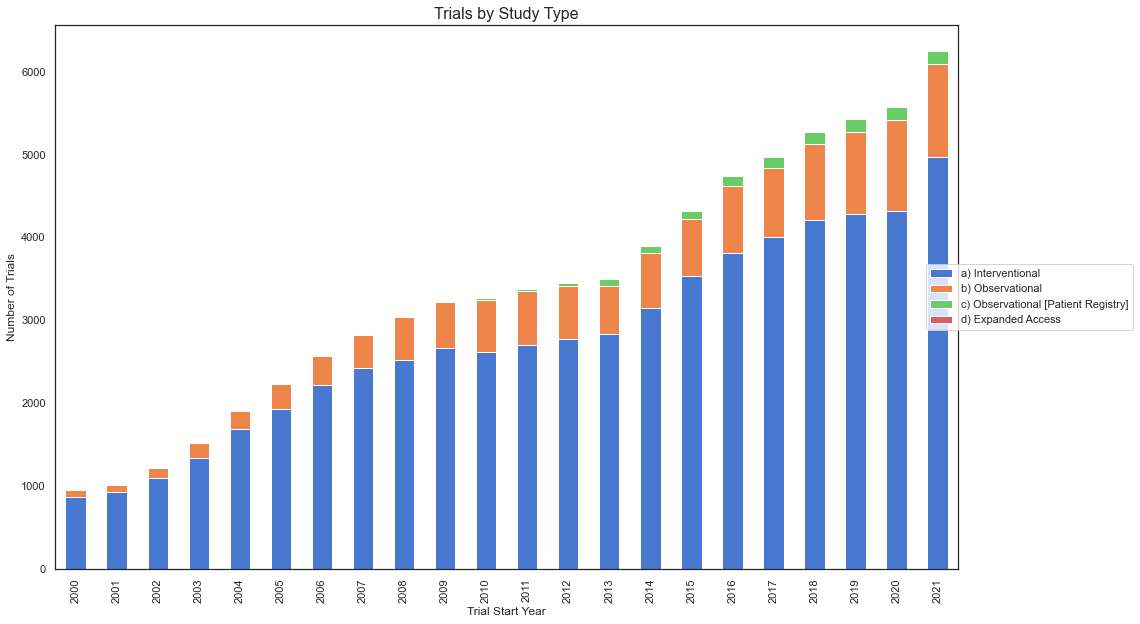

In [49]:
#Trials by Study Type
df=annual_stacked_bar(onc_trials, colname='mapped_study_type', collabel="Study Type")

<Figure size 1164.96x720 with 0 Axes>

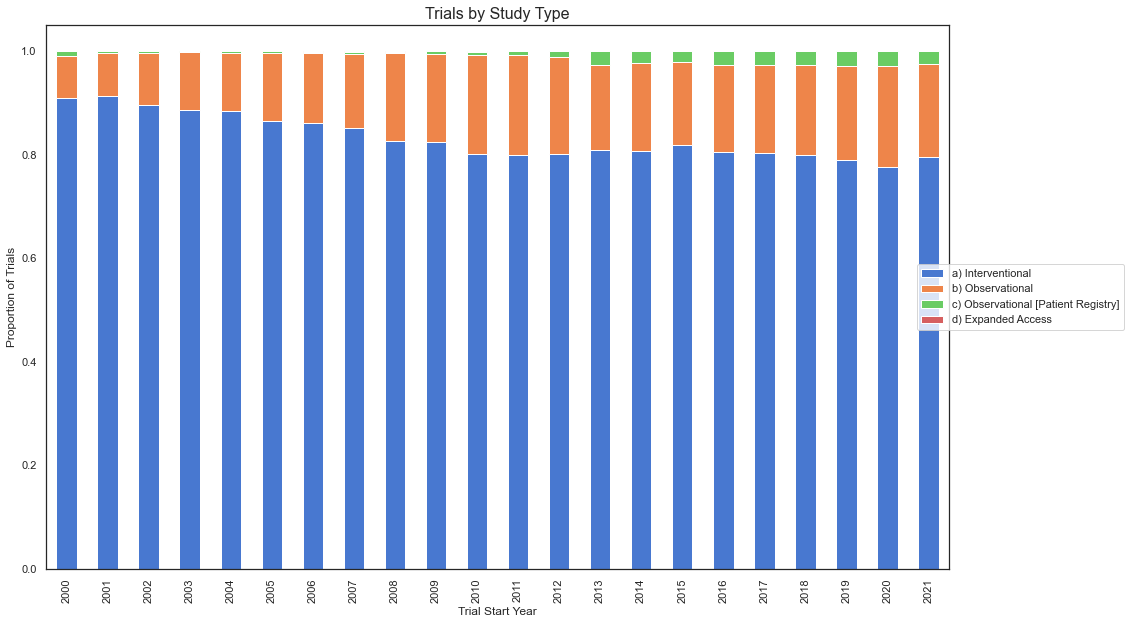

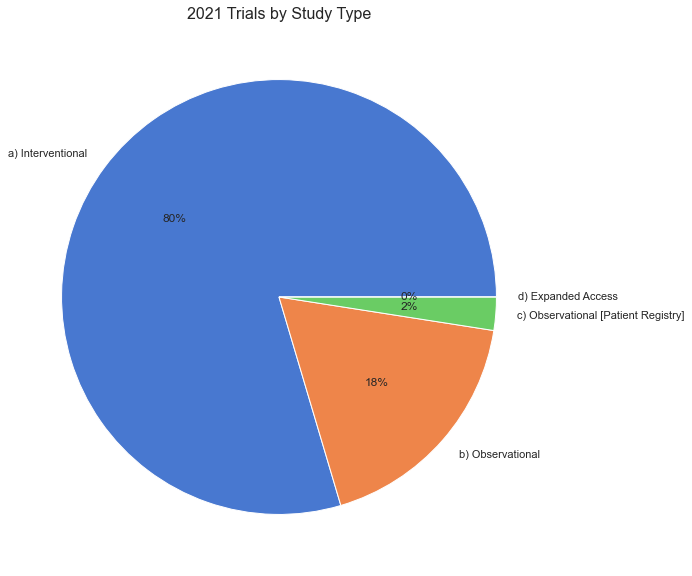

In [50]:
df=annual_stacked_bar_100(onc_trials, colname='mapped_study_type', collabel="Study Type")

In [38]:
# Trials by FDA Regulated Drug

<Figure size 1164.96x720 with 0 Axes>

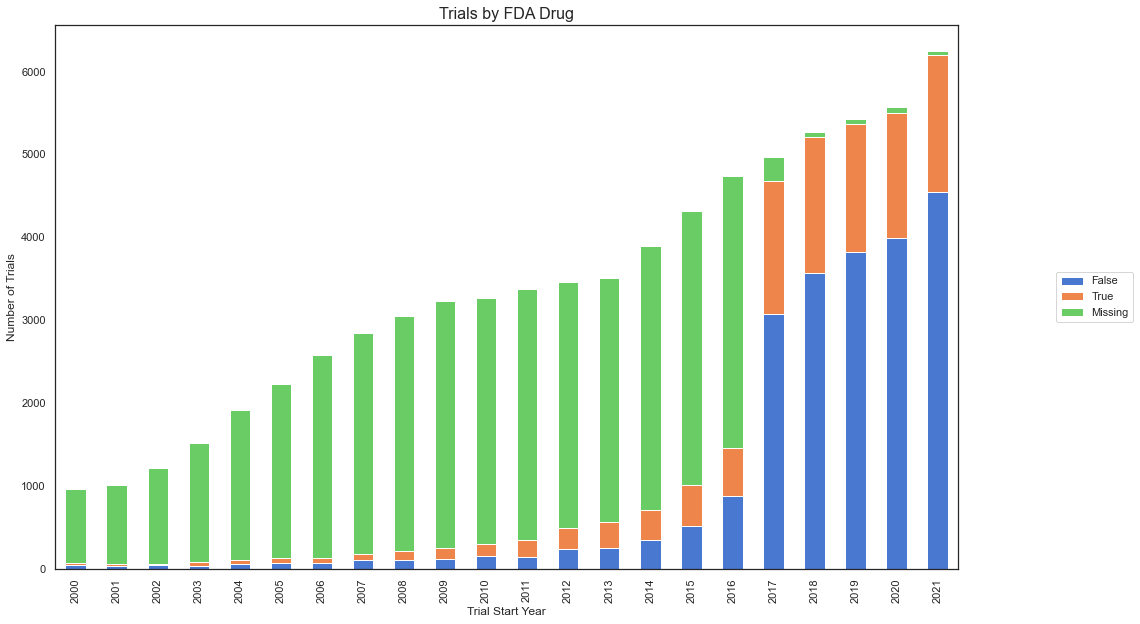

In [40]:
# Clean study column
# onc_trials['phase'].fillna('Null', inplace=True)

onc_trials['mapped_fda_drug']=onc_trials['is_fda_regulated_drug'].fillna('Missing')
df=annual_stacked_bar(onc_trials, colname='mapped_fda_drug', collabel="FDA Drug")

<Figure size 1164.96x720 with 0 Axes>

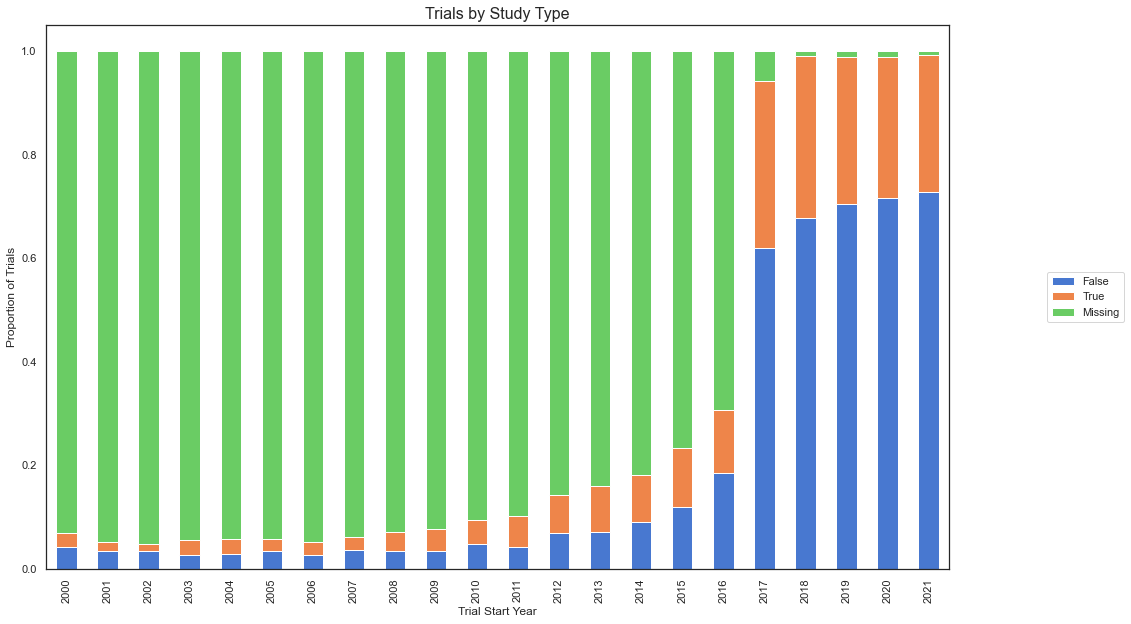

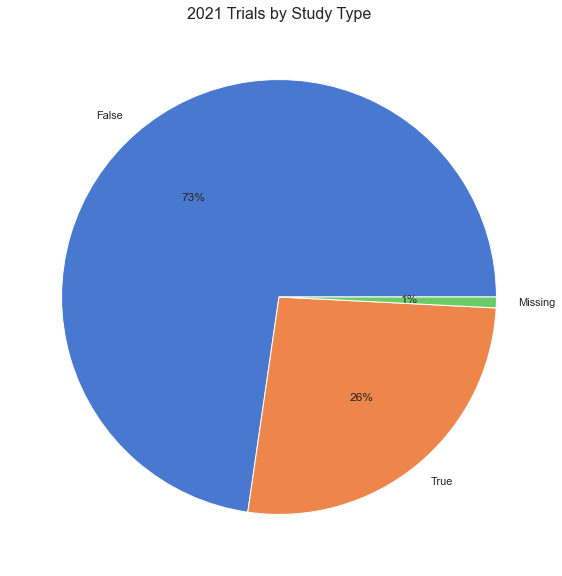

In [41]:
df=annual_stacked_bar_100(onc_trials, colname='mapped_fda_drug', collabel="Study Type")

In [25]:
# Trials by Conditions

In [26]:
trial_cond= onc_trials[['nct_id','conditions']]

In [27]:
trial_cond['condition_list']=trial_cond.conditions.apply(lambda x: x.split('|'))

/Users/forrest.xiao/miniconda3/envs/trialtrackerenv_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
trial_cond.head()

,nct_id,conditions,condition_list
0,NCT00000105,Cancer,[Cancer]
1,NCT00000124,Choroid Neoplasms|Uveitis,"[Choroid Neoplasms, Uveitis]"
2,NCT00000589,Blood Platelets|Blood Transfusion|Hematologic ...,"[Blood Platelets, Blood Transfusion, Hematolog..."
3,NCT00000591,Bone Marrow Transplantation|Graft vs Host Dise...,"[Bone Marrow Transplantation, Graft vs Host Di..."
4,NCT00000603,"Anemia, Aplastic|Fanconi Anemia|Hematologic Di...","[Anemia, Aplastic, Fanconi Anemia, Hematologic..."


In [29]:
t_cond = trial_cond[['nct_id','condition_list']].explode('condition_list')

In [30]:
t_cond.head()

,nct_id,condition_list
0,NCT00000105,Cancer
1,NCT00000124,Choroid Neoplasms
1,NCT00000124,Uveitis
2,NCT00000589,Blood Platelets
2,NCT00000589,Blood Transfusion


In [31]:
t_cond.shape

(184598, 2)

In [32]:
t_cond.condition_list.value_counts(normalize=True).head(10)

Breast Cancer        0.035710
Prostate Cancer      0.018635
Cancer               0.015466
Colorectal Cancer    0.013565
Lung Cancer          0.013007
Multiple Myeloma     0.010000
Lymphoma             0.009848
Ovarian Cancer       0.008315
Leukemia             0.008315
Pancreatic Cancer    0.007866
Name: condition_list, dtype: float64

In [33]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

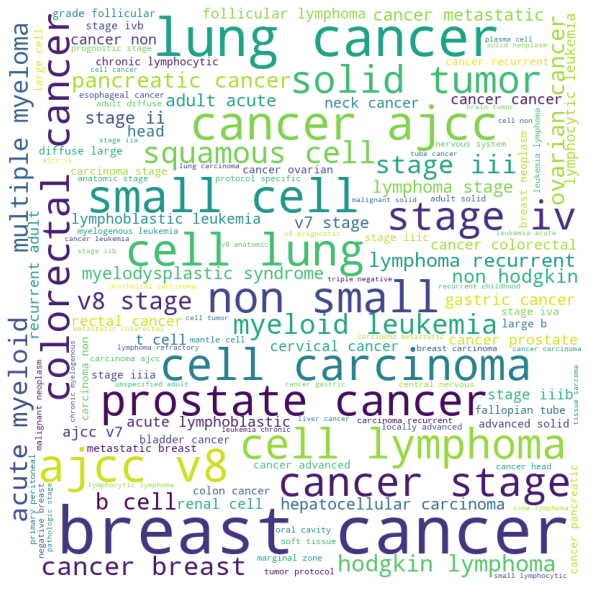

In [34]:
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in t_cond.condition_list:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

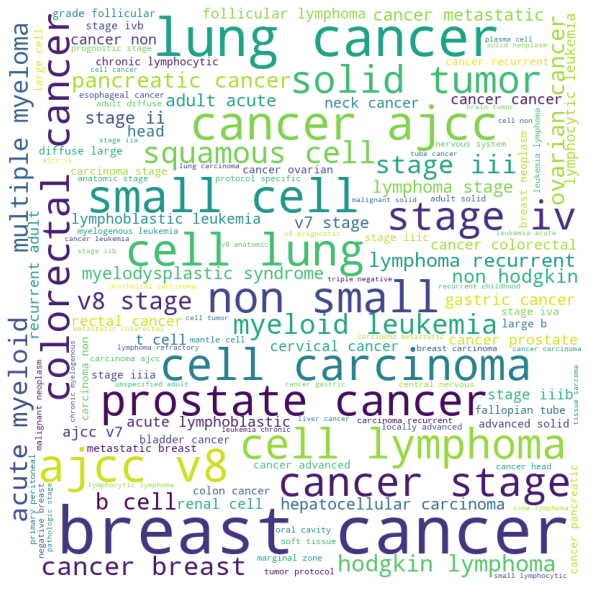

In [36]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
condition_cloud_path="./visuals/condition_cloud.png"
plt.savefig(condition_cloud_path, bbox_inches='tight')
 
plt.show()